<br>  
# SKIN CANCER IMAGE CLASSIFICATION
    
    SUSHANTH SHIVPURA RAMESH - C1044105
    Module :CSC8635
<br>

<br>

**Table of Content**

1. Abstract
2. Introduction
3. Data Set Overview
4. Dataset Loading 
5. Data Preprocessing
6. Numerical and Viziual Exploratary Data Analysis
7. Data Engineering
8. Model Building
    
    Image Augmentation <br>
    Class Weights <br>
    Evaluation Metric <br>
    Transfer Learning <br>
    VGG16 <br>
    ResNet50v2
9. Results & Conclusion
10. Future Scope
11. Personal Reflection
12. References 

<br>

***

# 1. Abstract

<p align ="justify">Skin cancer is one of the most common malignancies in humans. Early detection would require less medical intervention and there is a better survival rate if detected early . With the HAM data set which contains images of skin cancer lesions which were collected over years, our goal is to detect and classify the skin cancer images automatically without medical trained individual. This can be implemented by using Deep learning models with Transfer Learning. The project is implemented with VGG-16 and Resnet50v2 Convoluted Neural Network (CNN) with weights assigned due to imbalance between each classes. The images were augmented before training before prediction of the 7 classes of skin cancer.</p> 

**Keywords**: 
*Transfer Learning, VGG16, Resnet50, Convoluted Neural Network(CNN), Image Augmentation*

# 2. Introduction

<p align ="justify">Skin Cancer is one of the most common and growing diseases across the world. The majority of Skin cancer cases are attributed to excessive exposure to UV radiation. It is usually diagnosed visually, starting with a clinical screening or by a dermoscopic examination, followed by a biopsy for confirmation. The survival rate is about 99% for those who are detected and treated in the early stage before it spreads to other parts of the body [1].</p> 

<p align ="justify">By leveraging the extensive use of Machine learning and deep learning methods in the field of medical sciences, we will be able to build an automatic system for the classification of skin lesions which would help detect a malignancy at a early stage without much medical intervention needed.</p>

<p align ="justify">In this project, we are trying to build predictive deep learning model using Convolutional Neural Network (CNN) to classify the skin cancer images.  The implemented models are based on CNN architecture VGG-16 and Resnet50v2, which can classify 7 different types of skin cancer which is present in the data set. </p>


# 3. Data Set Overview


<p align ="justify">HAM10000 ("Human Against Machine with 10000 training images")  is an open skin cancer data set containing dermatoscopic images from different populations which can serve as a training set for academic machine learning purposes. The 10015-image data were collected over a 20-year period from two separate locations: the Department of Dermatology at the Medical University of Vienna, Austria, and Cliff Rosendahl's skin cancer practice in Queensland, Australia.[2] There are 7 classes of skin cancer pigmented lesions in the dataset which are as follows:</p>
 
*   Actinic keratoses (akiec) 
*   Basal cell carcinoma (bcc)
*   Benign keratosis-like lesions (bkl)
*   Dermatofibroma (df)
*   Melanoma (mel)
*   Melanocytic nevi (nv) 
*   vascular lesions ( vasc)

With corresponding image data set a meta data is also given which consists of: 

*   lesion_id
*   Image_id
*   dx_type(Cancer class)
*   age (patient age)
*   sex
*   localization (Area of cancer on the body)


In [ ]:
# intializing and mapping the GPU using tensorflow
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
# Importing Libraries


from google.colab import files
import os
import zipfile
from scipy import misc
import math
import shutil

import numpy as np
import pandas as pd
from numpy import expand_dims
from glob import glob

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For image handling
from PIL import Image


# 4. Dataset Loading 

In [ ]:
# Authenticating Kaggle to downlaod the dataset
# Download the the kaggle.Json from you kaggle account and upload the json to the collab and run the cell:
files.upload()
#!files.upload()
!mkdir ~/.kaggle    #create a kaggle folder
!cp kaggle.json ~/.kaggle  #copying the kaggle.json file to folder
!chmod 600 /root/.kaggle/kaggle.json #permission for the json to act
print("Imported kaggle API successfully !")

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Imported kaggle API successfully !


In [ ]:
# Creating folder structure to downlaod the data and uzip it 

try:
  os.mkdir("/content/skin_can")
except FileExistsError: 
  print("Folder Already Exists!")

try: 
  os.mkdir("/content/skin_can/data_set")
except FileExistsError:
  print("Folder Already Exists!") 


Folder Already Exists!
Folder Already Exists!


In [ ]:
# downloading the data set and uzipping 

%%capture
print("Downloading dataset : ")
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
print("Downloaded Successfully!")

# if you are unable to  load your Kaggle json and download the dataset directly to google collab 
# download the data set from kaggle and palce the data set in the following path "/content" and run the other steps sequentially 



In [ ]:
%%capture
!mv /content/skin-cancer-mnist-ham10000.zip /content/skin_can/data_set #moving the data set to the folder 
!unzip /content/skin_can/data_set/skin-cancer-mnist-ham10000.zip -d /content/skin_can/data_set # uzipping
!rm -rf "/content/skin_can/data_set/ham10000_images_part_1" , "/content/skin_can/data_set/ham10000_images_part_2" # removing duplicate data 


# 5. Data Pre-processing

<p align ="justify">In this section we are going to prepare and wrangle the data for numerical and visual data analysis before we begin the data engineering and model building.</p>

In [ ]:
# creating the data frame with the metadat.csv for EDA
metadata_df = pd.read_csv("/content/skin_can/data_set/HAM10000_metadata.csv")
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Storing the Acronyms of the cancer types as key value pair in dictionary 
canc_label = {
    'akiec': 'Actinic keratoses',
    'bkl': 'Benign keratosis lesions ',
    'bcc': 'Basal cell carcinoma',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'vasc': 'Vascular lesions'
}

canc_keys = []
for i in canc_label.keys():
  canc_keys.append(i)
print(canc_keys)
canc_values = []
for j in canc_label.values():
  canc_values.append(j) 
#print(canc_values)

['akiec', 'bkl', 'bcc', 'df', 'nv', 'mel', 'vasc']


In [ ]:
# mapping the dx with the key value above for EDA
metadata_df['dx'] = metadata_df['dx'].map(canc_label.get)
metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign keratosis lesions,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign keratosis lesions,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign keratosis lesions,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign keratosis lesions,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign keratosis lesions,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Actinic keratoses,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,Actinic keratoses,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,Actinic keratoses,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,Actinic keratoses,histo,80.0,male,face


In [ ]:
# Finding if there are any Missing values in the metadata
metadata_df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [ ]:
# summary of the age column
metadata_df["age"].describe()

count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

Text(0.5, 1, 'Age Distribution across Patients')

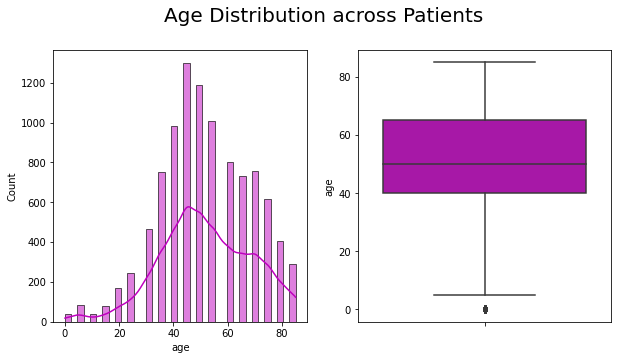

In [ ]:
# Plotting age distribution in meta data
fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.histplot(data=metadata_df, x="age", kde=True, color = 'm',ax=axes[0])
sns.boxplot( data=metadata_df,y=metadata_df["age"], color = 'm', ax=axes[1])
fig.suptitle('Age Distribution across Patients', y=1,fontsize=20)


<p align ="justify">From the above numerical analysis, we see that there are 57 missing values in the age column. We can see from the plots above that age in the dataset follows a normal distribution curve (bell curve). So, we will replace the null values with the mean value of the age.</p>

In [ ]:
# replacing the null values with mean age value 
metadata_df['age'].fillna((metadata_df['age'].mean()), inplace=True)
metadata_df.isna().sum()


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

# 6. Numerical and Viziual Exploratary Data Analysis

<p align ="justify">In this section we will perform some numerical and visual analysis to get some insights about the data set. This would also help us to identify any anomalies in the data set and select the important features to build our ML model efficiently.</p>

In [ ]:
# No of patients in each class of cancer in the data set
df_count = metadata_df["dx"].value_counts().rename_axis('cancer_type').reset_index(name='count')
df_count

,cancer_type,count
0,Melanocytic nevi,6705
1,Melanoma,1113
2,Benign keratosis lesions,1099
3,Basal cell carcinoma,514
4,Actinic keratoses,327
5,Vascular lesions,142
6,Dermatofibroma,115


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

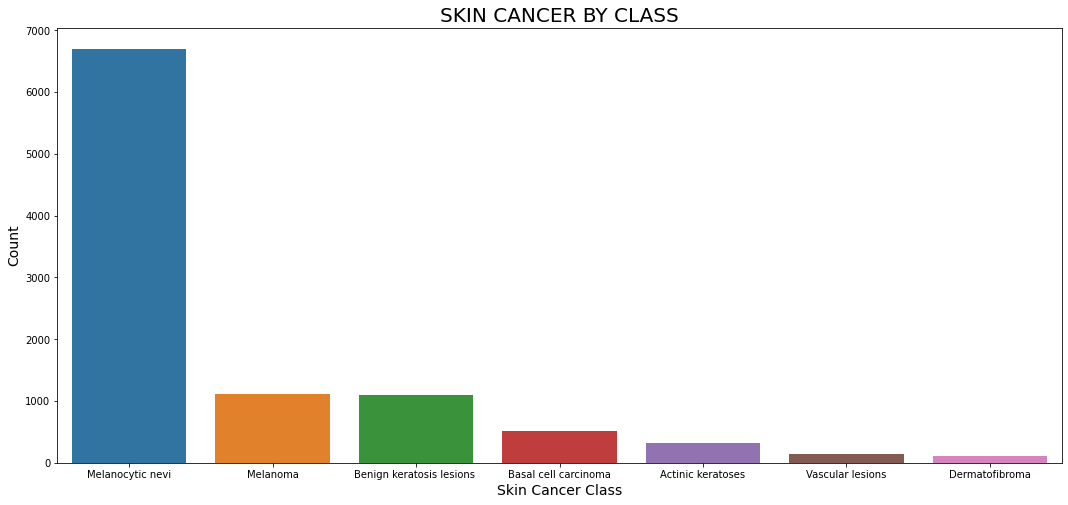

In [ ]:
#plotting skin cancer count by class
plt.figure(figsize=(18,8))
canc_typ=sns.countplot(metadata_df['dx'],order=metadata_df['dx'].value_counts().index)
canc_typ.set_title('SKIN CANCER BY CLASS', fontsize=20)
canc_typ.set_xlabel('Skin Cancer Class', fontsize=14)
canc_typ.set_ylabel('Count', fontsize=14)


<p align ="justify">From the above table and plot we can see that Melanoctic Nevi class has the highest count of data points i.e. 6705 images and Dermatofibroma has the least number of images i.e. 115. we can conclude that the dataset is highly imbalanced.</p>

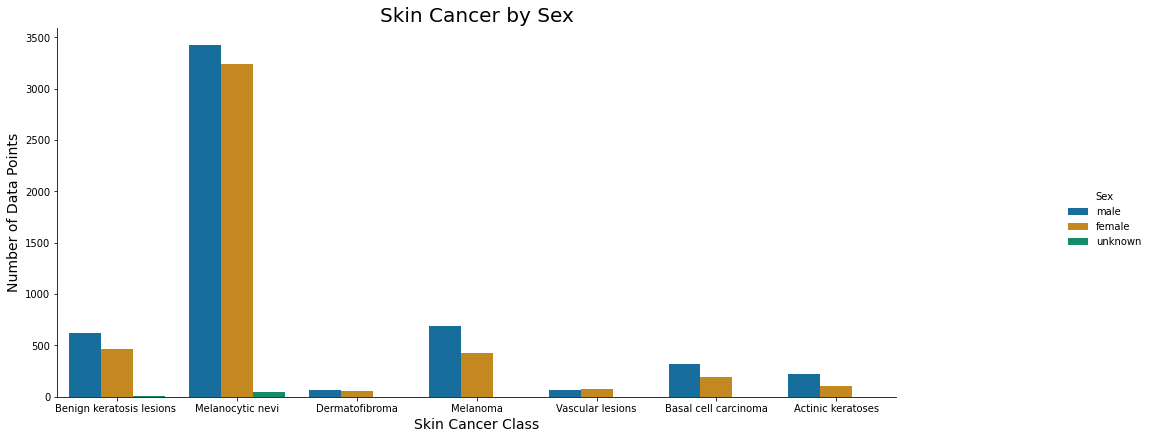

In [ ]:
#plotting skin cancer by sex
can_sex= sns.catplot(x="dx", kind="count", hue="sex", palette='colorblind', data=metadata_df)
can_sex.fig.set_size_inches(18, 6)
can_sex.ax.set_title('Skin Cancer by Sex', fontsize=20)
can_sex.set_xlabels('Skin Cancer Class', fontsize=14)
can_sex.set_ylabels('Number of Data Points', fontsize=14)
can_sex._legend.set_title('Sex')

<p align ="justify">From we the above plot we observe that the Male and Female patients for each class of cancer is nearly equal in count.</p> 

In [ ]:
# Finding unique types
print(metadata_df["dx_type"].unique())

['histo' 'consensus' 'confocal' 'follow_up']


Text(0.5, 1.02, 'Count of patients based on lesions confirmed Method')

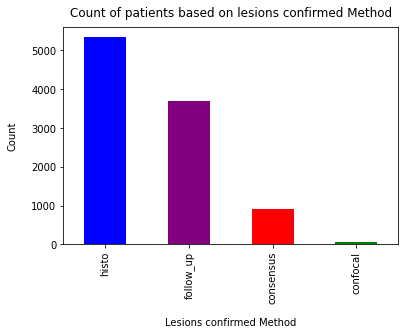

In [ ]:
# Plotting the counts for each unique type
metadata_df["dx_type"].value_counts().plot(kind = "bar", color=["blue", "purple", "red", "green" ])
plt.xlabel("Lesions confirmed Method", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of patients based on lesions confirmed Method", y=1.02)

From the above plot we can see that the highest confirmed patients was from histology and follow up. we will not be considering this for training our model

Text(0, 0.5, 'Count')

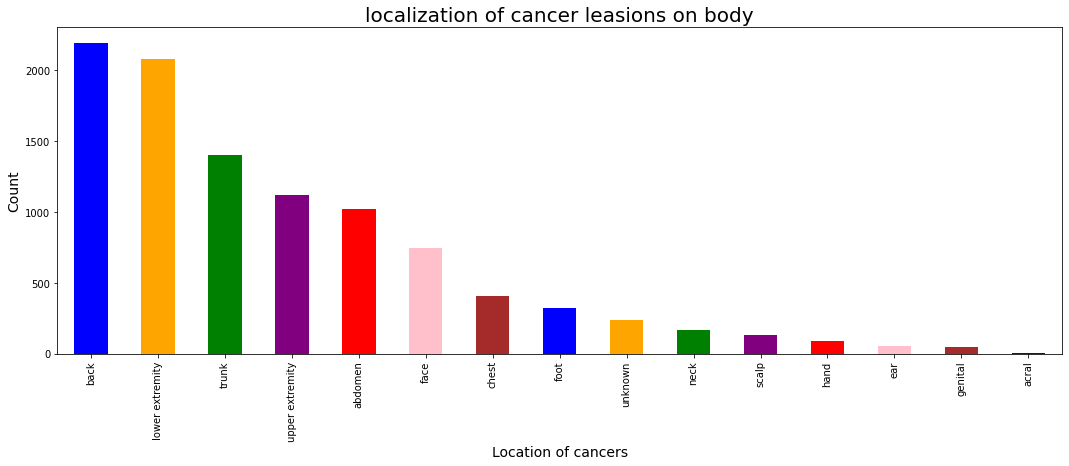

In [ ]:
plt.figure(figsize=(18, 6))
palette_color = sns.color_palette('bright')
canc_loc=metadata_df['localization'].value_counts().plot(kind='bar' ,color=["blue", "orange", "green", "purple", "red", "pink", "brown"]) 
canc_loc.set_title('localization of cancer leasions on body', fontsize=20)
canc_loc.set_xlabel('Location of cancers', fontsize=14)
canc_loc.set_ylabel('Count', fontsize=14)


#skin_df['localization'].value_counts().plot(kind='bar', title="Location of cancers")

In [ ]:
# Finding % for each class in the data
df_count["Percentage"] = (df_count["count"] / len(metadata_df) * 100)
df_count

,cancer_type,count,Percentage
0,Melanocytic nevi,6705,66.949576
1,Melanoma,1113,11.113330
2,Benign keratosis lesions,1099,10.973540
3,Basal cell carcinoma,514,5.132302
4,Actinic keratoses,327,3.265102
5,Vascular lesions,142,1.417873
6,Dermatofibroma,115,1.148278


Text(0.5, 1.05, 'Percentage distribution of  cancer classes in the  dataset')

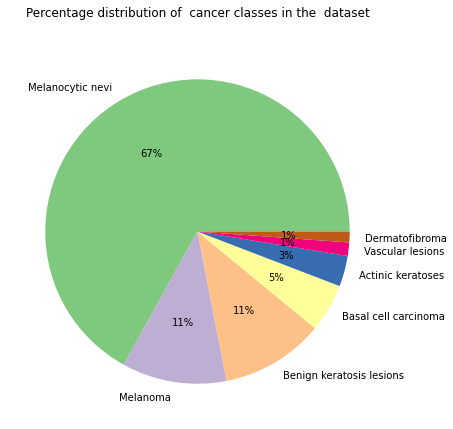

In [ ]:
import seaborn as sns
plt.figure(figsize=(18,7))
palette_color = sns.color_palette('Accent')
plt.pie(df_count["Percentage"], labels=df_count["cancer_type"], colors=palette_color,  autopct='%.0f%%')
plt.title("Percentage distribution of  cancer classes in the  dataset", y=1.05)


<p align ="justify">In an image classification problem, it I required to have a balanced number of images in each of the classes for the model to train without any biases. Most of the machine learning models or algorithms assume that the data is distributed across the classes equally. If we train a model with imbalanced data the prediction will not be efficient and will have a bias towards the majority class as the algorithm will not have much data to train on the classes that have less data. As a result the predictions are not optimized. The second problem is that with fewer number of images in some classes it would be difficult to divide the data set to train, test and validation set.</p>
<p align ="justify">From the above pie chart and table, we can clearly see that Melanocytic nevi class of cancer has the majority of the images that is about 67%.  Dermatofibroma and Vascular lesions class have only 1% of images to train on. This will result in class imbalance problem. This can be solved by assigning weights to the classes while training the model.</p> 


# 7. Data Engineering

<p align ="justify">In this section we will engineer the data before we start to train the model. The skin cancer images are in two folders "HAM10000_images_part_1" and "HAM10000_images_part_2”. The following steps are implemented below: </p>  

1.   Consolidate  all images into a single folder
2.   Create a sub folder structure based on the class names i.e. 7 classes
3.   Using the metadata.csv we will map the image id to dx (class names) and push the images to their respective folders
4. Split the data into training, validation and test sets.


In [ ]:
# creating a folder to consolidate the images
try:
  os.mkdir("/content/consolidate/")
except FileExistsError: 
  print("Folder Already Exists!")

In [ ]:
# setting source and destination directories 
src1_dir = "/content/skin_can/data_set/HAM10000_images_part_1"
src2_dir = "/content/skin_can/data_set/HAM10000_images_part_2"
dst_dir = "/content/consolidate/"
metadata_df2 = pd.read_csv("/content/skin_can/data_set/HAM10000_metadata.csv")
# Copying images 
for images1 in glob(os.path.join(src1_dir, "*.jpg")):
    shutil.copy(images1, dst_dir)

for images2 in glob(os.path.join(src2_dir, "*.jpg")):
  shutil.copy(images2, dst_dir)

In [ ]:
# verifying if the all the data is copied 
len(os.listdir("/content/consolidate/"))

10015

In [ ]:
# saving the class labels in a list
labels = [] 
for i in metadata_df2["dx"].unique():
  labels.append(i)
labels

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

In [ ]:
try: 
  os.mkdir("/content/clean_data/")
except FileExistsError:
  print("Folder Already exists")
data_dir = "/content/consolidate/"
dest_dir = "/content/clean_data/" # folder under which the 7 classes in folder 

In [ ]:
# copying the images to thier respective class folders 
label_images =[]
for i in labels:
    os.mkdir(dest_dir +str(i) + "/")
    sample = metadata_df2[metadata_df2['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + id +".jpg"), (dest_dir  + i + "/"+id+".jpg"))
    label_images = []
    


<p align ="justify">With the split-folder module we can divide the data into Test, Validation and training set as per our required ratio for all the class subfolders with we created previously. This will also take care of having not having any duplicate images in Test, validation and Training sets.</p>

In [ ]:
# installing the split-folders module
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# estimating the no of images in each class in test , val and training set to validate it after the splitting is done below 
df_split_cal = metadata_df["dx"].value_counts().rename_axis('cancer_type').reset_index(name='counts')
df_split_cal["Percentage"] = (df_split_cal["counts"] / len(metadata_df) * 100)
df_split_cal["train_set"] =round((df_split_cal["Percentage"]/100) * 8012) # 80% training set
df_split_cal["val_set"] = round((df_split_cal["Percentage"]/100) * 1001)  # 10% validation set
df_split_cal["test_set"] = round((df_split_cal["Percentage"]/100) * 1001) # 10% test set
df_split_cal = df_split_cal.sort_values("cancer_type")
df_split_cal

,cancer_type,counts,Percentage,train_set,val_set,test_set
4,Actinic keratoses,327,3.265102,262.0,33.0,33.0
3,Basal cell carcinoma,514,5.132302,411.0,51.0,51.0
2,Benign keratosis lesions,1099,10.973540,879.0,110.0,110.0
6,Dermatofibroma,115,1.148278,92.0,11.0,11.0
0,Melanocytic nevi,6705,66.949576,5364.0,670.0,670.0
1,Melanoma,1113,11.113330,890.0,111.0,111.0
5,Vascular lesions,142,1.417873,114.0,14.0,14.0


<p align ="justify">The below command will split the data based on the specified ratio (.8, .1 , .1) , which is 80 % of our data will be for Training, 10 % for validation and the remaining 10 % for Testing our model.</p> 

In [ ]:
splitfolders.ratio("/content/clean_data/", output="/content/engg_data/",seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=True)

Copying files: 10015 files [00:01, 6029.10 files/s]


In [ ]:
# validating the split fuctions with the values from the table 
len(os.listdir("/content/engg_data/train/nv")), len(os.listdir("/content/engg_data/val/mel"))

(5364, 111)

<p align ="justify">We see that there are 5364 images in the Melanocytic nevi class in Training set and 111 images in Melanoma class in validation set. This matches with the calculated values from the above table.</p>

# 8. Model building

In [88]:
# imorting modules and packages required for building and training the model
import random
np.random.seed(1356)
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import shutil

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.metrics import PrecisionAtRecall, Recall, CategoricalAccuracy
from tensorflow.keras.metrics import Precision
from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint 



<p align ="justify">With the engineered data from the previous section The data is ready to be used for training our models.In this Section we will build machine learing models and train them. 
As noted in our EDA the data is imbalnced, so to solve this we will assign weights for each class while training our model.For better results we would also used image augmentation techinque before we train our model.</p>

### Image Augmentation 

<p align ="justify">As we know that some of the classes such as dermatofibroma, Vascular lesion classes have very less images to train. As our data set is a health care data set, it is very difficult to collect actual data.  To tackle this problem, we use Image augmentation technique. Using image augmentation, we can transform the original images to create some training data set by rotating, flipping, adding noises or blurring the images. This would help us in training the Deep Neural Network with larger data set and will also avoid overfitting a model to some extent.</p>
<p align ="justify">This has been implemented below with ImageDataGenerator Class with Keras library. The parameters used for augmentation used is as below:</p>


*   Rotated by 20%
*   Sheared by 10%
*   Zoomed by 10% 
*   Horizontal flip

<p align ="justify">Apart from this for ResNet50V2 model we have used an inbuilt function in keras for image augmentation called resnet_v2. preprocess_input in ImageDataGenerator Class.</p>


In [ ]:
# assigning the test, train and validation image path
train_path = "/content/engg_data/train"
test_path = "/content/engg_data/test"
val_path = "/content/engg_data/val"

In [ ]:
# image preprocess function for Resnet50V2 model 
imgen_train_val= ImageDataGenerator(#shear_range=0.1, zoom_range = 0.2,
                                           #horizontal_flip=True, shear_range =0.1)                   # uncommnet and run the code to run with image aug 
                                     preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

imgen_test = ImageDataGenerator(#shear_range=0.2, zoom_range = 0.2,
                                           #horizontal_flip=True,shear_range =0.1)
                                preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)


In [ ]:
targ_size = (224, 224)

train_data = imgen_train_val.flow_from_directory(directory=train_path, 
                                                          target_size=targ_size,
                                                          color_mode="rgb",
                                                          class_mode = "categorical",
                                                          batch_size=16)

val_data = imgen_train_val.flow_from_directory(directory=val_path, 
                                                          target_size=targ_size,
                                                          color_mode="rgb",
                                                          class_mode = "categorical",
                                                          batch_size=16)

test_data = imgen_test.flow_from_directory(directory=test_path, 
                                                          target_size=targ_size,
                                                          color_mode="rgb",
                                                          class_mode = "categorical",
                                                          batch_size=16)

Found 8010 images belonging to 7 classes.
Found 998 images belonging to 7 classes.
Found 1007 images belonging to 7 classes.


### Class Weights

<p align ="justify">Another way of addressing the problem of class imbalance i.e uneven distribution of data in each class is by assigning class weights while training the model. As this is a classification problem and most of the Deep learning algorithms wills assume our data is evenly distributed, which is not in our case. As a result if we train the model with out the class weights assigned the results will be skewed towards predicting the majority class.</p>

<p align ="justify">Though we may get a good accuracy in the model the f1-score of the minority class will be very small. To address this we have calculated the class weights of each of the class below with inbuilt module in sklearn using class_weight.compute_class_weight function.</p>


In [ ]:
class_type = train_data.class_indices
class_type

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train_data.classes), 
                                                  y = train_data.classes)
weight_dict = dict(enumerate(class_weights))
weight_dict 

{0: 4.384236453201971,
 1: 2.78415015641293,
 2: 1.3018039980497318,
 3: 12.437888198757763,
 4: 1.2857142857142858,
 5: 0.21332694151486098,
 6: 10.126422250316056}

### Transfer-Learning

<p align ="justify">Transfer Learning (TL) is the of weights from pre-trained model to a new deep learning model. Transfer Learning is mainly used on Image classification or natural language processing to learn from previously trained or labelled images. This helps in speed up the training ad improve the performance of the prediction. This also helps when the data bases of the training images are less. One of the most common weights that is used in image classification is ImagNet which has been trained on 14 million labelled images. Using this pretrained weights will help us reducing the number of layers to train and improve the learning rate and optimize the results of the prediction.[3]</p>

### VGG16 Model
<p align ="justify">We will be using VGG16 and Resnet50V2 models with ImageNet weights to train our model. Additional layers on top of the base layers that are tailored to our classification problem. VGG16 model with imageNet can classify up to 1000 classes. It is one of the best performing models on images and has achieved a 92.7 percent test precision on the 14 million ImageNet dataset.[4] This model is also widely been used on medical images like X-ray and MRI data sets. The input size of the images are 224 X 224. The model is fine-tuned as required with optimizers and model parameters as explained below.[5]</p>

In [ ]:
#vgg16

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


# Using pre-trained model (Trained on imagenet)
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

vgg_out = base_model.output
vgg_out = GlobalAveragePooling2D()(vgg_out)
output = tf.keras.layers.Dense(7, activation="softmax")(vgg_out)
vgg_model = tf.keras.models.Model(inputs = [base_model.input], outputs = [output])

print(vgg_model.summary())




Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from keras import backend as K

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred

# Calculating precision
def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_pos / (predicted_pos + K.epsilon())
    return precision

# Calculating recall
def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_pos / (possible_pos + K.epsilon())
    return recall

# Calculating f1 metric
def f1_metric(y_true, y_pred):
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_pos / (predicted_pos + K.epsilon())
    recall = true_pos / (possible_pos + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

metric = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'), precision, recall, f1_metric]

### Performance Metrics
<p align ="justify">The performance of the model after the training can be measured in different metrics. One of the most common metric used is accuracy. In our problem we can get the best accuracy of the model, but the actual classification result would not be true as our data set is imbalanced, as the model would be biased towards majority class. As the data set is imbalanced, a better way to measure the performance of the model is by F1-score. F1 score of the model is calculated by the mean of all individual class scores.</p>

<p align ="justify">F1 score is the weighted average of Precision and Recall as shown below:</p>

**F1 Score = 2x(Recall * Precision)/ (Recall x Precision)**


In [ ]:
optim = Adam(learning_rate=0.001)
#optim =Adam
vgg_model.compile(optimizer = optim, loss = "categorical_crossentropy", metrics = metric)
print("Model vgg_model compilation completed.")

Model vgg_model compilation completed.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor= "val_accuracy", mode = "max",min_delta= 0.01, patience = 5, verbose=1) # min_delta= 0.01,
# If model improves it will automatically save it
model_chpnt = ModelCheckpoint(filepath="vgg16_model.h5", monitor="val_accuracy", verbose=1, save_best_only= True, mode="max")

The Model is fine-tuned with some Hyper Parameters as below:


*   Optimizer: Adam with learning rate set to 0.001 which is simple and computationally efficient with large umber of data and parameters. which also helps in setting the learning rate

*   Loss Function: Categorical Cross-Entropy used for single label classification problem as our single image belongs to only one of 7 classes
*   Epochs: 30.  set along with call back function


*    Batch size: After some trial was set to 16 which yielded the best result

Early call back is also implemented which ensures that the model stops training when the Validation accuracy is not improving for 5 consecutive times.

In [ ]:
# fitting the model
vgg_hist = vgg_model.fit(train_data, epochs = 30, validation_data = val_data, 
                          callbacks = [early_stop,model_chpnt],
                                       class_weight = weight_dict)

Epoch 1/30
501/501 [==============================] - ETA: 0s - loss: 1.8084 - accuracy: 0.4096 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 2.3482e-04
Epoch 1: val_accuracy improved from -inf to 0.42285, saving model to vgg16_model.h5
501/501 [==============================] - 95s 189ms/step - loss: 1.8084 - accuracy: 0.4096 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 2.3482e-04 - val_loss: 1.6642 - val_accuracy: 0.4228 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metric: 0.0037
Epoch 2/30
501/501 [==============================] - ETA: 0s - loss: 1.6223 - accuracy: 0.5161 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0327
Epoch 2: val_accuracy improved from 0.42285 to 0.47094, saving model to vgg16_model.h5
501/501 [==============================] - 95s 189ms/step - loss: 1.6223 - accuracy: 0.5161 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0327 - val_loss: 1.6476 - val_accuracy: 0.4709 - val_precision: 0.0000e

In [ ]:
acc = vgg_model.evaluate(test_data, verbose = 1)
print(f"The accuracy for VGG16 model on the test data set is: {acc[1] * 100} %")

63/63 [==============================] - 11s 177ms/step - loss: 1.4749 - accuracy: 0.4628 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.2144
The accuracy for VGG16 model on the test data set is: 46.276068687438965 %


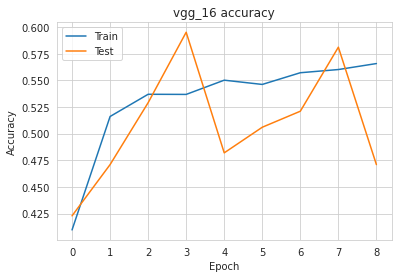

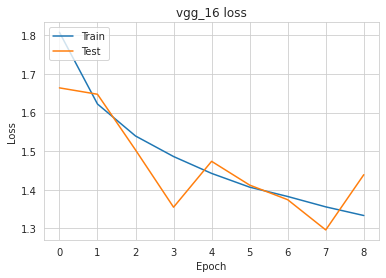

In [ ]:
# Plot training & validation accuracy values
sns.set_style("whitegrid")
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('vgg_16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
sns.set_style("whitegrid")
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('vgg_16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
Y_pred = vgg_model.predict(test_data)
y_pred = np.argmax(Y_pred, axis = 1)
print("Confusion Matrix Vgg_16")
cnf_mtx = confusion_matrix(test_data.classes, y_pred)
print(cnf_mtx)

Confusion Matrix Vgg_16
[[  2   2   3   8   3  14   2]
 [  0   4   1  20   9  14   4]
 [  7  13   6  36  12  34   3]
 [  0   0   0   4   2   6   0]
 [  3  12   7  28   5  47  10]
 [ 29  37  29 155 108 245  68]
 [  0   6   1   2   1   4   1]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


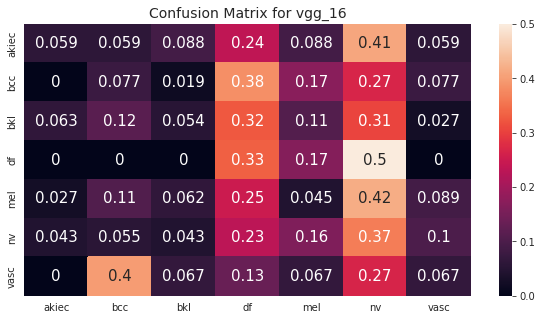

In [ ]:
# Plotting confuion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matr = pd.DataFrame(cnf_mtx, index = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
                           columns = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
#Normalizing
conf_matr = conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10, 5))
plt.title("Confusion Matrix for vgg_16", fontsize = 14)
sns.heatmap(conf_matr, annot=True, annot_kws={"size": 15})

The above image shows the confusion matrix for VGG16 without image augmentation.

In [ ]:
from sklearn.metrics import classification_report

target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(test_data.classes, y_pred, target_names = target_names))

              precision    recall  f1-score   support

       akiec       0.05      0.06      0.05        34
         bcc       0.05      0.08      0.06        52
         bkl       0.13      0.05      0.08       111
          df       0.02      0.33      0.03        12
         mel       0.04      0.04      0.04       112
          nv       0.67      0.37      0.47       671
        vasc       0.01      0.07      0.02        15

    accuracy                           0.27      1007
   macro avg       0.14      0.14      0.11      1007
weighted avg       0.47      0.27      0.33      1007



<p align ="justify">From the above metrics we see that the accuracy for VGG16 with out image augmentation was 46 % .From the confusion matrix and classifiacation report we can see that the F1-score for minority class are nearly zero and the model is not predicting the images wich had less number of images to train from.</p>

So, we will try to train the image on a different model i.e ResNet50v2

## ResNet50V2 Model
<p align ="justify">Residual Neural Network (ResNet) is also one of the efficient Convolution Neural networks this used commonly for image recognition. Resnet50v2 consists of 50 deep layers . like the VGG16 this model also uses pre-trained ImageNet weights and had only an error rate of 3.5% on the ImageNet data set.[6] The issue of Vanishing gradient is implemented by skip connections in Resnet to train the model efficiently and minimizing the errors. 
The Model is fine-tuned with some Hyper Parameters as below:</p>


*   Optimizer: Adam with learning rate set to 0.001 which is simple and computationally efficient with large number of data and parameters. which also helps in setting the learning rate

*   ReduceLROnPlateau : This hyper parameter is implemented to reduce the learning rate of the model and try to retrain the model when the validation accuracy is not increasing

*   Loss Function: Categorical Cross-Entropy used for single label classification problem as our single image belongs to only one of 7 classes


*   Epochs: 40. set along with call back function


*   Batch size: After some trial was set to 16 which yielded the best result

Early call back is also implemented which ensures that the model stops training when the Validation accuracy is not improving for 3 consecutive times.


In [ ]:
#resnet50


base_model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

res_mod = base_model.output
res_mod = GlobalAveragePooling2D()(res_mod)
res_mod = tf.keras.layers.Dense(128, activation = "relu")(res_mod)
res_mod = tf.keras.layers.Dropout(0.2)(res_mod)
output = tf.keras.layers.Dense(7, activation="softmax")(res_mod)
resn_model = tf.keras.models.Model(inputs = [base_model.input], outputs = [output])

print(resn_model.summary())

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
optim = Adam(learning_rate=0.001)
  
resn_model.compile(optimizer = optim, loss = "categorical_crossentropy", metrics = metric)
print("Model ResNet 50v2 compilation completed.")

Model ResNet 50v2 compilation completed.


In [89]:
learn_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_metric', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


early_stop = EarlyStopping(monitor= "val_f1_metric", mode = "max", min_delta= 0.01, patience = 3, verbose=1)
# If model improves it will automatically save it
model_chpnt = ModelCheckpoint(filepath="Resnetv50_model.h5", monitor="val_f1_metric", verbose=1, save_best_only= True, mode="max")

In [ ]:
# Fitting the model 
resnet_hist = resn_model.fit(train_data, epochs = 40,batch_size = 16, validation_data = val_data, 
                          callbacks = [learn_rate, early_stop, model_chpnt], 
                          class_weight = weight_dict)

Epoch 1/50
501/501 [==============================] - ETA: 0s - loss: 1.4808 - accuracy: 0.4627 - precision: 0.0917 - recall: 0.0925 - f1_metric: 0.3662
Epoch 1: val_f1_metric improved from -inf to 0.43680, saving model to renset50v2.h5
501/501 [==============================] - 128s 227ms/step - loss: 1.4808 - accuracy: 0.4627 - precision: 0.0917 - recall: 0.0925 - f1_metric: 0.3662 - val_loss: 1.2979 - val_accuracy: 0.5150 - val_precision: 0.1746 - val_recall: 0.1058 - val_f1_metric: 0.4368 - lr: 0.0010
Epoch 2/50
501/501 [==============================] - ETA: 0s - loss: 1.1136 - accuracy: 0.5569 - precision: 0.2087 - recall: 0.1928 - f1_metric: 0.5170
Epoch 2: val_f1_metric improved from 0.43680 to 0.58798, saving model to renset50v2.h5
501/501 [==============================] - 103s 206ms/step - loss: 1.1136 - accuracy: 0.5569 - precision: 0.2087 - recall: 0.1928 - f1_metric: 0.5170 - val_loss: 1.0375 - val_accuracy: 0.6072 - val_precision: 0.3016 - val_recall: 0.2910 - val_f1_met

In [ ]:
acc = resnet_hist.evaluate(test_data, verbose = 1)
print(f"The accuracy for ResNet 50v2 model on the test data set is: {acc[1] * 100} %")

63/63 [==============================] - 15s 229ms/step - loss: 0.4676 - accuracy: 0.8367 - precision: 0.5132 - recall: 0.5476 - f1_metric: 0.8308
The accuracy for ResNet 50v2 model on the test data set is: 83.66733193397522 %


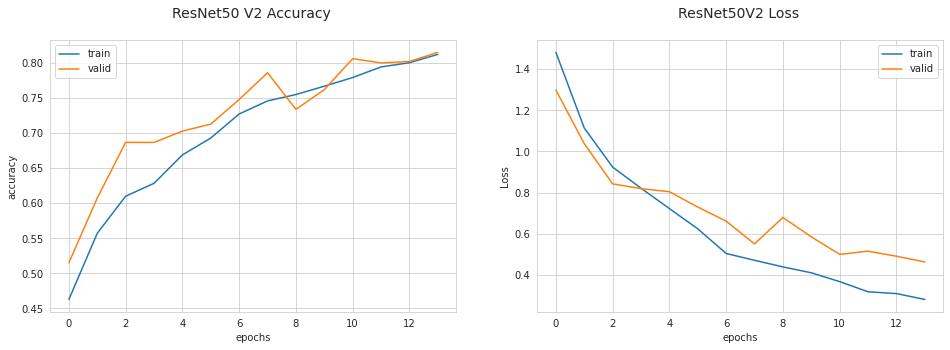

In [ ]:
fig = plt.figure(figsize=(16, 5))
#  subplot #1
plt.subplot(121)
import seaborn as sns 
sns.set_style("whitegrid")
plt.plot(resnet_hist.history["accuracy"], label = "train")
plt.plot(resnet_hist.history["val_accuracy"], label = "valid")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("ResNet50 V2 Accuracy \n", fontsize = 14)
plt.legend()

#  subplot #2
plt.subplot(122)
import seaborn as sns 
sns.set_style("whitegrid")
plt.plot(resnet_hist.history["loss"], label = "train")
plt.plot(resnet_hist.history["val_loss"], label = "valid")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("ResNet50V2 Loss \n", fontsize = 14)
plt.legend()

plt.show()

In [ ]:
Y_pred = resn_model.predict(test_data)
y_pred = np.argmax(Y_pred, axis = 1)
print("Confusion Matrix ResNet 50v2")
cnf_mtx = confusion_matrix(test_data.classes, y_pred)
print(cnf_mtx)

Confusion Matrix ResNet 50v2
[[  1   1   6   0  10  16   0]
 [  2   7   3   1  13  25   1]
 [  6   5  15   3  22  60   0]
 [  1   0   2   0   2   6   1]
 [  4  13  17   3  22  50   3]
 [ 21  45  91   8 118 375  13]
 [  1   2   0   0   3   9   0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


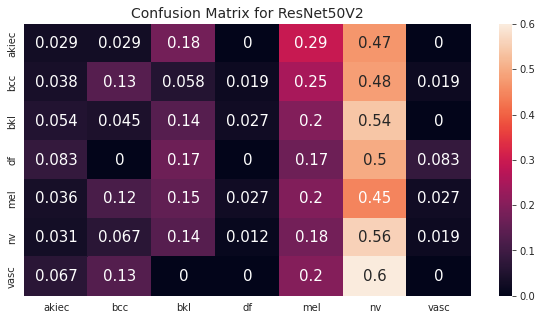

In [ ]:
# Plotting confuion matrix

conf_matr = pd.DataFrame(cnf_mtx, index = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
                           columns = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
#Normalizing
conf_matr = conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10, 5))
plt.title("Confusion Matrix for ResNet50V2", fontsize = 14)
sns.heatmap(conf_matr, annot=True, annot_kws={"size": 15})

The above fig shows the confusion matrix for ResNet50v2 model without image augmentation.

In [ ]:
from sklearn.metrics import classification_report

target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(test_data.classes, y_pred, target_names = target_names))

              precision    recall  f1-score   support

       akiec       0.06      0.06      0.06        32
         bcc       0.02      0.02      0.02        51
         bkl       0.13      0.16      0.14       109
          df       0.00      0.00      0.00        11
         mel       0.10      0.15      0.12       111
          nv       0.67      0.57      0.61       670
        vasc       0.00      0.00      0.00        14

    accuracy                           0.42       998
   macro avg       0.14      0.14      0.14       998
weighted avg       0.47      0.42      0.44       998



In [ ]:
pd.crosstab(test_data.classes, y_pred, rownames = ["Actual"], colnames = ["Predicted"], margins = True)

Predicted,0,1,2,3,4,5,6,All
Actual,,,,,,,,
0,2,1,3,0,5,20,1,32
1,4,1,10,0,10,26,0,51
2,5,8,17,0,20,56,3,109
3,1,0,0,0,1,9,0,11
4,5,6,11,1,17,69,2,111
5,19,46,92,9,114,379,11,670
6,0,3,0,0,1,10,0,14
All,36,65,133,10,168,569,17,998


<p align ="justify">Above is the metric score and prediction table for different skin cancer classes of ResNet50V2 class . we can observe that the model is not predicting 'df' and 'vasc' classes at all. As per over EDA ,this is observed because that these two classes have the lowest count of images in the dataset whereas nv has the highest therefore it has a good F1-score compare to others.If the there is class imbalances as in our case, it is better to use a weighted macro-averaging score to measure the performance of the model.</p>

# 9. Results and Conclusion


|                    | Resnet50V2 with img Augmentation | Resnet50V2 without img Augmentation | VGG16 with img Augmentation | |
|--------------------|--------------------------|---------------------------------|-----------------------|------------------------------|
| **Cancer Classes** |                          | **f1-scores**                   |                       |                              |
| akiec              | 0.00                     | 0.06                            | 0.05                                         |
| bcc                | 0.03                     | 0.02                            | 0.06                                         |
| bkl                | 0.11                     | 0.14                           | 0.08                                          |
| df                 | 0.00                     | 0.05                            | 0.00                                          |
| mel                | 0.11                     | 0.12                           | 0.10                                          |
| nv                 | 0.59                     | 0.61                            | 0.47                                           |
| vasc               | 0.01                     | 0.05                            | 0.02                                           |

<p align ="justify">There were two models trained that is, VGG16 with image augmentation and ResNet50V2 with and without image augmentation. As the data set was imbalanced striking for better accuracy will create an illusion that the model is performing better. To have balance with f1-score, precession and recall metrics will justify for our use case.</p> 
<p align ="justify">From the above table we can clearly see that the models trained with image augmentation have a better F1-scores and can predict more classes accurately. The highest accuracy was achieved on ResNet50V2 model without image augmentation i.e 84% on test and 82.66% validation set and there was a decrease in accuracy to 73% with image augmentation.VGG16 had an accuracy of about 46 %  accuracy and had a lower F1-scores  compared to ResNet50V2 without Image augmentation. Training the models with the class weights removed will increase the accuracy but the results are skewed towards the classes with large image data.</p>
<p align ="justify">Overall from the above table we can see the F1-scores of the minority classes such as Actinic keratoses (akiec) , Vascular lesions (vas) and Dermatofibroma (df) have a score that is nearly equal to  zero in most of the trained models .This infers that these models will not predict these category of skin cancers and there is no promising results in these learning models.</p>


# 10. Future Scope

<p align ="justify">The future scope of work is to improve the prediction and classification accuracy by fine tuning the model hyper parameters and used other image augmentation techniques. As the data set was imbalanced, we could try exploring ways to collect images which are less. Pretrained weights i.e imagenet was used to train the model, other pretrained weights such as CIFAR and MNIST can be used to train the model to see if the accuracy improves. After the top model is trained i.e ReNet50 or VGG16 we could further more add and customize the layers and train the model to see if the performance improves. Finally, we could explore ways to use data such as age, sex, localization in our machine learning model to extract more information.</p>

# 11. Personal Reflection

<p align ="justify">By Implementing this Image classification, machine learning project it has given me an extensive experience in tackling various problems and given me an opportunity to explore different tools. I have used Google collab to build this project , which helped in reducing the training time of the model with the cloud GPU rather than running on my personal computer. This also helped me stream line the project from the start to end like a pipeline along with markdown text to create the report simultaneously.</p> 
<p align ="justify">The machine learning models were implemented using Keras and Tensorflow. I have also used libraries such as Pandas, Matplotlib and Seaborn for exploratory data analysis and visualization which helped me learn data analysis techniques and improve my python coding skills. I have also explored new modules such as split-folder which helped me reducing the number of lines in the code and reducing my effort. The most time-consuming and challenging part for me was model selection and building as well as data engineering. Overall, I have enjoyed working on this project overcoming various hurdles along the way which was an experience for future projects.</p>



# 12. References

<p align ="justify">[1] Wilson, Brooke E; Jacob, Susannah; Yap, Mei Ling; Ferlay, Jacques; Bray, Freddie; Barton, Michael B (2019). Estimates of global chemotherapy demands and corresponding physician workforce requirements for 2018 and 2040: a population-based study. The Lancet Oncology, (), S1470204519301639–. doi:10.1016/S1470-2045(19)30163-9 </p>
<p align ="justify">[2] https://arxiv.org/pdf/1902.03368.pdf </p>
<p align ="justify">[3] K. Pai and A. Giridharan, "Convolutional Neural Networks for classifying skin lesions," TENCON 2019 - 2019 IEEE Region 10 Conference (TENCON), 2019, pp. 1794-1796, doi:
10.1109/TENCON.2019.8929461.</p>
<p align ="justify">[4] Tschandl, Philipp, Cliff Rosendahl, and Harald Kittler. "The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions." Scientific data
5.1 (2018): 1-9.</p>
<p align ="justify">[5]  https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c </p>
<p align ="justify">[6] W. F. Chabala and I. Jouny, "Comparison of Convolutional Neural Network Architectures on
Dermastopic Imagery," 2020 11th IEEE Annual Ubiquitous Computing, Electronics & Mobile
Communication Conference (UEMCON), 2020, pp. 0928-0931, doi:
10.1109/UEMCON51285.2020.9298059.</p>